In [1]:
from scraper import Scraper as BoxscoreScraper

In [2]:
scraper = BoxscoreScraper(year=2023)

In [3]:
scraper.get_season_boxscores()

Beginning scraping for 2023-2024 season



  0%|          | 0/1 [00:00<?, ?it/s]

Scraping boxscores for Week 1
Succesfully scraped boxscores for Week 1



In [5]:
from filing import Filing

import pandas as pd
class Cleaning:

    def __init__(self, **kwargs):
        """
        This class will contain the functionality to combine, clean, wrangle, and partition all the boxscores
        """

        self.year: int = int(kwargs.get('year', 2023))
        self.season: str = f'{self.year}-{self.year+1}'

        # Initialize filing object
        self.filing = Filing(self.season)

        # ppr_coeff = 0.5 if kwargs.get('hppr', False) else 1.0      
        self.raw: pd.DataFrame = (self.filing.combined()
                                  # .assign(fpts=lambda df: 0.04*df.pass_yds + 4.0*df.pass_td - 1.0*df.pass_int + 0.1*df.rush_yds + 6.0*df.rush_td + ppr_coeff*df.rec + 0.1*df.rec_yds + 6.0*df.rec_td - 1.0*df.fumbles_lost)
                                 )
        self.positions: pd.DataFrame = self.filing.positions()



In [30]:
cleaning = Cleaning(year=2022)

In [31]:
df = cleaning.raw

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5382 entries, 0 to 5381
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             5382 non-null   object 
 1   team             5382 non-null   object 
 2   pass_cmp         5382 non-null   int64  
 3   pass_att         5382 non-null   int64  
 4   pass_yds         5382 non-null   int64  
 5   pass_td          5382 non-null   int64  
 6   pass_int         5382 non-null   int64  
 7   pass_sacked      5382 non-null   int64  
 8   pass_sacked_yds  5382 non-null   int64  
 9   pass_long        5382 non-null   int64  
 10  pass_rating      5382 non-null   float64
 11  rush_att         5382 non-null   int64  
 12  rush_yds         5382 non-null   int64  
 13  rush_td          5382 non-null   int64  
 14  rush_long        5382 non-null   int64  
 15  targets          5382 non-null   int64  
 16  rec              5382 non-null   int64  
 17  rec_yds       

In [33]:
# Need to figure out how to classify position depth --> May run into issues with injuries

<Axes: >

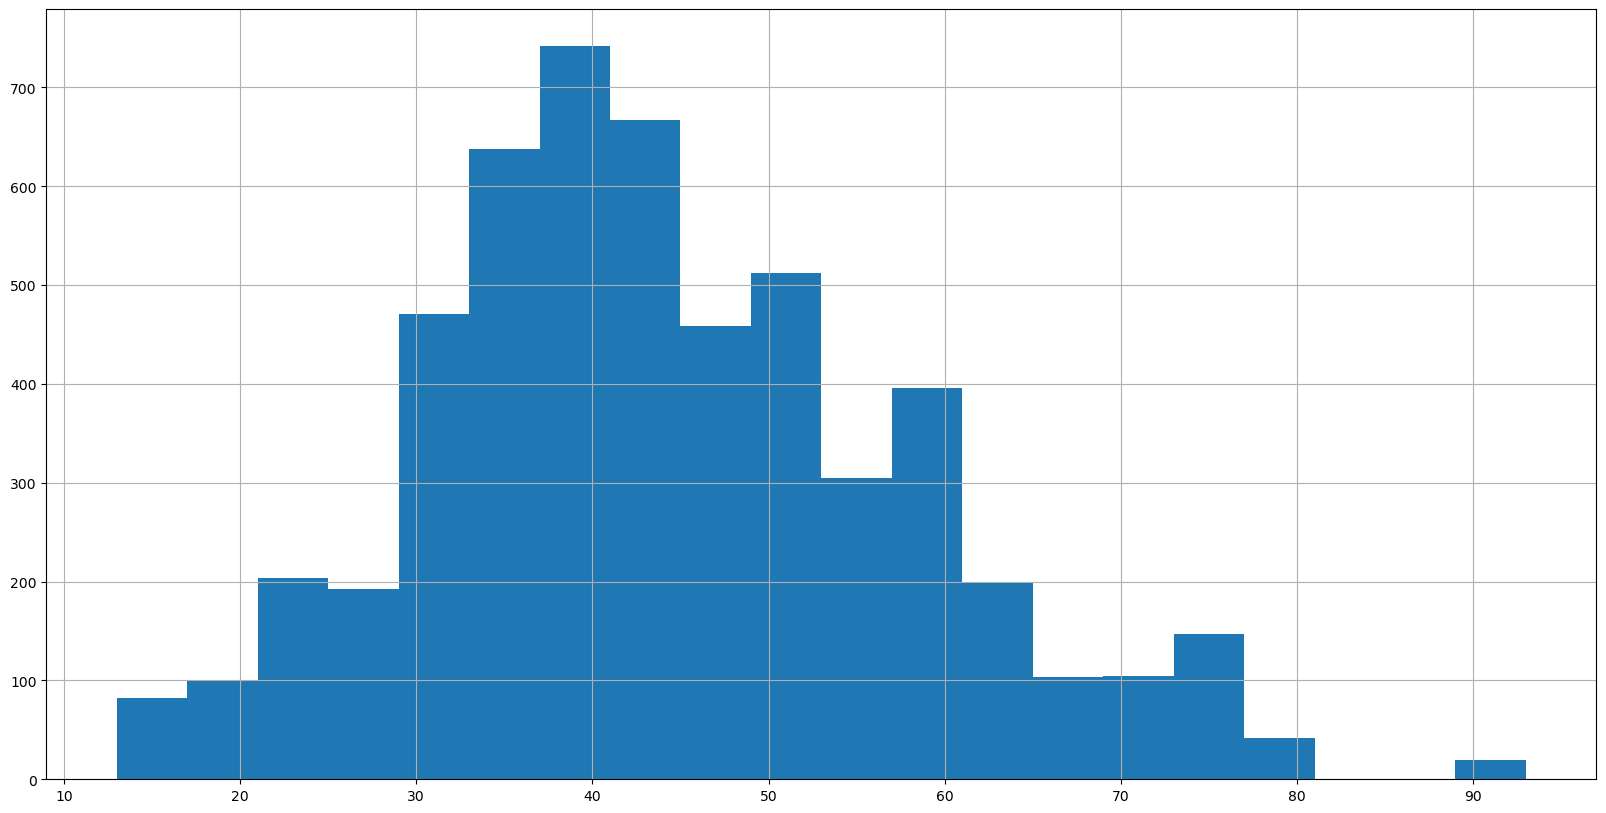

In [34]:
df['total'].hist(figsize=(20,10), bins=20)

In [35]:
import numpy as np
import scipy.stats as stats

import itertools

In [36]:

team_cores = {
    'MIN': [
        'Tyreek Hill',
        'Tua Tagovailoa',
        'Jaylen Waddle',
        'Raheem Mostert'
        
    ],

    'NE': [
        'Mac Jones',
        'Rhamondre Stevenson',
        'Kendrick Bourne',
        # 'JuJu Smith-Schuster'
        'DeVante Parker'

    ]
}
team_dfs = {
    team: df.loc[(df['team'] == team) & (df['name'].isin(core)) & (df['fpts'] > 0.0)] 
    for team, core in team_cores.items()
}

In [37]:
# Get the games core players have played in together
# Example: If AJ Brown is missing, DeVonta Smith might have a much better game than usual and will skew results OR
# he might have a much worse game since a better corner is most likely guarding him
team_core_together_weeks = {
    team: tuple(team_df
                .groupby('week')
                ['week']
                .agg(['count'])
                .pipe(lambda df_: df_.loc[df_['count'] == len(team_cores[team])])
                .index
               )
    for team, team_df in team_dfs.items()
}

In [38]:
team_core_fpts = {
    team: {
        name: [ (team_df.loc[(team_df['name'] == name) & (team_df['week'] == week ), 'fpts'].item()) for week in team_core_together_weeks[team] ]
        for name in team_cores[team]
    }

    for team, team_df in team_dfs.items()
}

In [39]:
agg_stats = ['mean']

In [40]:
team_combo_corrs = {
    team: dict(sorted({
        combo: round(stats.pearsonr(core_fpts[combo[0]], core_fpts[combo[1]])[0],3)
        for combo in itertools.combinations(team_cores[team], 2)
    }.items(), key=lambda item: item[1], reverse=True))
    for team, core_fpts in team_core_fpts.items()
}

ValueError: x and y must have length at least 2.

In [44]:
team_combo_corrs['MIA']

NameError: name 'team_combo_corrs' is not defined

In [42]:
team_combo_corrs['PHI']

NameError: name 'team_combo_corrs' is not defined

In [43]:
agg_stats = ['rush_yds', 'rush_td', 'rec_yds', 'rec_td']
teams = ['NE', 'MIA']

In [29]:
agg_df = (df
          .groupby('opp')
          [agg_stats]
          .agg(['sum'])
          .reset_index()
          .set_axis(['opp'] + agg_stats, axis=1)
          .pipe(lambda df_: df_.loc[df_['opp'].isin(teams)])
          .set_index('opp')
          .assign(
              total_yds=lambda df_: df_.rush_yds + df_.rec_yds,
              total_td=lambda df_: df_.rush_td + df_.rec_td 
          )
         )
agg_df

,rush_yds,rush_td,rec_yds,rec_td,total_yds,total_td
opp,,,,,,
MIA,233,3,229,1,462,4
NE,97,0,170,1,267,1


In [25]:
# agg_df.sort_values([
#     'fpts',
#     # 'total_td',
#     # 'total_yds',
#     'rec',
#     # 'rush_td',
#     'rush_yds',
# ], ascending=False)